<div style="display: top; background-image:url('https://d1.awsstatic.com/SageMaker/SageMaker%20reInvent%202020/ImgHead_Mohave.3b1df33baa5f71b53237bfa6911fb3adc4902c0e.png');background-position: center ;background-repeat: no-repeat;background-size: 100%; padding-top:20px;">
<div style="color:#FFFFFF; text-align: top;padding-bottom: 25px; padding-left: 15px"><h1 style="font-weight: 900;">Project DAY 2 - SOLUTION (Training & Processing Job) </h1>
</div>
</div>
<br>

In this notebook, we go over SageMaker Training- and Processing Jobs to predict the __isPositive__ field of an Amazon Product Review dataset. 

1. <a href="#1">Read the dataset</a> (Given) 
2. <a href="#2">Train a model</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Data processing</a>
    * <a href="#24">Model training</a>
3. <a href="#3">Make predictions on the test dataset</a> (Implement)
4. <a href="#4">Evaluate accuracy</a> (Given)
__Notes on [AWS SageMaker](https://docs.aws.amazon.com/sagemaker/index.html):__

* Fully managed machine learning service, to quickly and easily get you started on building and training machine learning models - we have seen that already! Integrated Jupyter notebook instances, with easy access to data sources for exploration and analysis, abstract away many of the messy infrastructural details needed for hands-on ML - you don't have to manage servers, install libraries/dependencies, etc!


* Apart from building custom machine learning models in SageMaker notebooks, like we did so far, SageMaker also provides a few [built-in common machine learning algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) (check "SageMaker Examples" from your SageMaker instance top menu for a complete updated list) that are optimized to run efficiently against extremely large data in a distributed environment. The trained model can then be directly deployed into a production-ready hosted environment for easy access at inference. 



__Amazon Product Review Dataset__:

In this exercise, we are working with a product review dataset from Amazon. The raw data is available [here](https://nijianmo.github.io/amazon/index.html). You can find this dataset under __DATA/product-reviews__ in two variants (for regression or classification task): 
* *Amazon_Reviews_Regression.csv*
* *Amazon_Reviews_Classification.csv*

__Dataset schema:__ 

| __reviewText__      | __summary__ | __verified__     | __time__ | __log_votes__ | __isPositive__ |
| :---        |    :----:   |       :----:   |      :----:   |      :----:   |         ---: |
| Full text of the product review      | Summary text of the review       | Verified purchase? (True or False)  | UNIX timestamp for the review | Logarithm-adjusted votes log(1+votes)  | Positive review? (1 - yes or 0 - no) |

__isPositive__ - This is the field to predict.

In [1]:
# #Upgrade dependencies
# !pip install --upgrade -q pip
# !pip install --upgrade -q scikit-learn
# !pip install -U -q sagemaker

In [2]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
import nltk
from nltk.stem import SnowballStemmer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [3]:
# Read in the dataset
df = pd.read_csv("../../DATA/product-reviews/Amazon_Reviews_Classification.csv")

# We split between train and test data
training_data, test_data = train_test_split(df, test_size=0.15, random_state=1)

print("The shape of the training dataset is:", training_data.shape)
print("The shape of the test dataset is:", test_data.shape)

The shape of the training dataset is: (59500, 6)
The shape of the test dataset is: (10500, 6)


## 2. <a name="2">Train a model</a> (Implement)
(<a href="#0">Go to top</a>)

 * <a href="#21">Exploratory Data Analysis</a>
 * <a href="#22">Select features to build the model</a>
 * <a href="#23">Data processing</a>
 * <a href="#24">Model training</a>

### 2.1 <a name="21">Exploratory Data Analysis</a> 
(<a href="#2">Go to Train a model</a>)

Look at the number of rows, columns and some simple statistics of the dataset; `.head()` and `.info()` can help with this.

In [4]:
training_data.head(2)

reviewText  \
28204  Every year I upgrade. Guess I could skip it a ...   
5875   I have used TurboTax for the past four or five...   

                                summary  verified        time  log_votes  \
28204  Just my annual renewal as always     False  1391299200        0.0   
5875                 Helpful As Always!      True  1362268800        0.0   

       isPositive  
28204         1.0  
5875          1.0

In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59500 entries, 28204 to 5192
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  59490 non-null  object 
 1   summary     59489 non-null  object 
 2   verified    59500 non-null  bool   
 3   time        59500 non-null  int64  
 4   log_votes   59500 non-null  float64
 5   isPositive  59500 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 2.8+ MB


#### Model features vs model target
For further analysis seperate the model features from the target based on data type and using the information in the data schema.

In [6]:
# Split model target and features
model_target = "isPositive"  # 0 & 1
model_features = training_data.columns.drop(model_target).tolist()

Create the list of features (based on type). To split out numerical features for example:
    
`numerical_features = training_data[model_features].select_dtypes(include=np.number).columns`

We already know how to work with text and categorical features, so let's include those too.


In [7]:
# Split model features between categorical and numerical features
text_features = training_data.select_dtypes(include="object").columns.tolist()
numerical_features = (
    training_data.select_dtypes(include=np.number).columns.drop(model_target).tolist()
)
categorical_features = training_data.select_dtypes(include="bool").columns.tolist()

When working with text data, it is always good practice to cast the text columns to string. Make sure to do this for all splits of the dataset (train, validation & test).

In [8]:
training_data[text_features] = training_data[text_features].astype(str)
test_data[text_features] = test_data[text_features].astype(str)

Let's keep going with the EDA and plot histograms for all categorical features:

verified


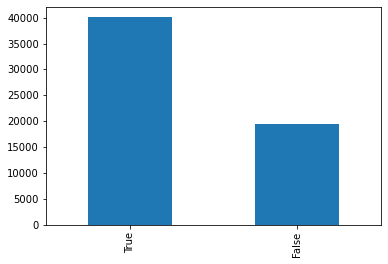

In [9]:
plt.figure(figsize=(6, 4))
for c in categorical_features:
    try:
        print(c)
        training_data[c].value_counts(sort=True)[
            :20
        ].plot.bar()  # only show 20 most frequent
        plt.show()
        plt.close()
    except:
        print("Could not plot feature %s" % c)
        pass

Let's keep going with the EDA and plot histograms for all text features:

reviewText


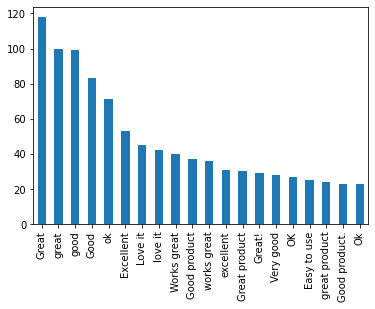

summary


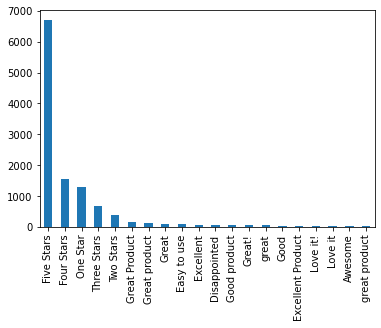

In [10]:
plt.figure(figsize=(6, 4))
for c in text_features:
    try:
        print(c)
        training_data[c].value_counts(sort=True)[
            :20
        ].plot.bar()  # only show 20 most frequent
        plt.show()
        plt.close()
    except:
        print("Could not plot feature %s" % c)
        pass

#### Target distribution

Let's have a look at the number of instances of class 0 and 1 respectively by using `.value_counts()`.

<AxesSubplot:>

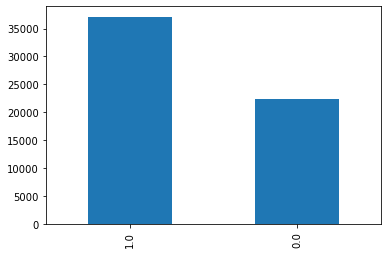

In [11]:
training_data[model_target].value_counts().plot.bar()

As the classes are imbalanced we want to upsample the underrepresented class.


In [12]:
print("Data set shape:", training_data.shape)

print("Class 0 samples in the data set:", sum(training_data[model_target] == 0))
print("Class 1 samples in the data set:", sum(training_data[model_target] == 1))

from sklearn.utils import shuffle

class_0_no = training_data[training_data[model_target] == 0]
class_1_no = training_data[training_data[model_target] == 1]

upsampled_class_0_no = class_0_no.sample(
    n=len(class_1_no), replace=True, random_state=42
)

training_data_upsampled = pd.concat([class_1_no, upsampled_class_0_no])
training_data_upsampled = shuffle(training_data_upsampled)

print("\nData set shape:", training_data_upsampled.shape)

print(
    "Class 0 samples in the data set:", sum(training_data_upsampled[model_target] == 0)
)
print(
    "Class 1 samples in the data set:", sum(training_data_upsampled[model_target] == 1)
)

Data set shape: (59500, 6)
Class 0 samples in the data set: 22367
Class 1 samples in the data set: 37133

Data set shape: (74266, 6)
Class 0 samples in the data set: 37133
Class 1 samples in the data set: 37133


#### Upsampled Data
To check that the upsampling worked as expected, let's plot the distribution again.

<AxesSubplot:>

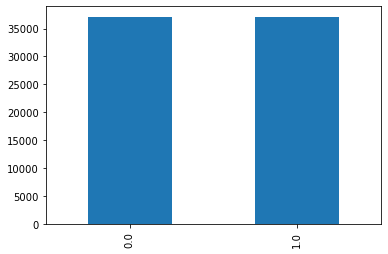

In [13]:
training_data_upsampled[model_target].value_counts().plot.bar()

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Train a model</a>)

Notice from EDA step that `time` is almost always unique and drop it from the features.

In [14]:
training_data_upsampled.drop(columns=["time"], inplace=True)
test_data.drop(columns=["time"], inplace=True)

In [15]:
# Also make sure to remove it from the feature list
numerical_features.remove("time")
model_features.remove("time")

### 2.3 <a name="23">Data Processing</a> 
(<a href="#2">Go to Train a model</a>)


During EDA we noticed a lot of similar words in the top most frequent values (they only differed by upper case/lower case). Hence, we want to clean our data before proceeding with the pipeline build.

In [16]:
# Prepare cleaning functions
stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer("english")


def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()

    # remove HTML tags
    text = re.compile("<.*?>").sub("", text)

    # remove punctuation
    text = re.compile("[%s]" % re.escape(string.punctuation)).sub(" ", text)

    # remove extra white space
    text = re.sub("\s+", " ", text)

    return text


def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)

    return text


def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

<div class="audun_warn"><i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Cleaning text can take a few minutes, depending on how much text is there to process. We will hand off the pre-processing to a SageMaker Processing job.
</div>

In [17]:
train_data, test_data = training_data, test_data

### 2.4 <a name="24">Model training/fitting</a> 
(<a href="#2">Go to Train a model</a>)
   
We will now use SageMaker Processing jobs in combination with __ColumnTransformer__. To do this, we need to provide authentication and create a pre-processing file.

In [18]:
import os
from os import path
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

In [19]:
# Find default bucket and create subfolders with prefix and key
bucket = sagemaker.Session().default_bucket()
prefix = "XGBoost-project"
key = "project-data.csv"

### Creating pre-processing file
We will now hand off the pre-processing to another instance. For this, we need to create a `.py` file that contains all the pre-processing steps and information on how to ingest data and return data. This new Python file then needs to be stored in a folder from which we can upload it later. We start by creating the folder:

In [20]:
!mkdir -p /home/ec2-user/SageMaker/processing

Now we create a Python file from within our notebook. We can achieve this with 

```
%%writefile /home/ec2-user/SageMaker/processing/preprocessing.py
```

This command will write the cell content into a Python file.

In [49]:
%%writefile /home/ec2-user/SageMaker/processing/preprocessing.py
from __future__ import print_function

# System libraries
import time
import sys
from io import StringIO
import os
import shutil
import ast

# Language libraries
import re, string

# Data prep libraries
import argparse
import csv
import json
import joblib
import numpy as np
import pandas as pd

# Machine Learning libraries
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer, StandardScaler, OneHotEncoder, MinMaxScaler,FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

# SageMaker libraries
from sagemaker_containers.beta.framework import (
    content_types,
    encoders,
    env,
    modules,
    transformer,
    worker,
)

# Provide a list with all numerical features
numerical_features = [
    "log_votes",
]

# Provide a list with all categorical features
categorical_features = [
    "verified",
]

# Provide a list with all text features
text_features = [
    'reviewText', 'summary'
]

# Since we get a headerless CSV file we specify the column names here.
feature_columns_names =  text_features + categorical_features + numerical_features

label_column = "isPositive"

# Get data types for features and target
feature_columns_dtype = {
    "log_votes": "float64",
    "verified": "boolean",
    "reviewText": "str",
    "summary": "str",
}

label_column_dtype = {"isPositive": "float64"}

def merge_two_dicts(x, y):
    z = x.copy()  # start with x's keys and values
    z.update(y)  # modifies z with y's keys and values & returns None
    return z

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument(
        "--output-data-dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"]
    )
    parser.add_argument("--model-dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--train", type=str, default=os.environ["SM_CHANNEL_TRAIN"])

    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    input_files = [os.path.join(args.train, file) for file in os.listdir(args.train)]
    if len(input_files) == 0:
        raise ValueError(
            (
                "There are no files in {}.\n"
                + "This usually indicates that the channel ({}) was incorrectly specified,\n"
                + "the data specification in S3 was incorrectly specified or the role specified\n"
                + "does not have permission to access the data."
            ).format(args.train, "train")
        )

    raw_data = [
        pd.read_csv(
            file,
            header=None,
            names=[label_column] + feature_columns_names,  # label first, then features
            dtype=merge_two_dicts(label_column_dtype, feature_columns_dtype),
        )
        for file in input_files
    ]

    concat_data = pd.concat(raw_data, axis = 0)
    #concat_data.drop(label_column, axis=1, inplace=True)
    
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy='median'),
        MinMaxScaler())

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(handle_unknown='ignore'))

    text_transformer = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        FunctionTransformer(np.reshape, kw_args={'newshape':-1}),
        CountVectorizer(binary=True, max_features=10))


    preprocessor = ColumnTransformer(transformers=[
            ("num", numeric_transformer, make_column_selector(dtype_include="float")),
            ("cat", categorical_transformer, make_column_selector(dtype_include="category")),
            ("txt_0", text_transformer, [text_features[0]]),
            ("txt_1", text_transformer, [text_features[1]]),

    ], remainder="drop")
    
    print(concat_data.head())
    print(concat_data.columns)
    
    preprocessor.fit(concat_data)

    joblib.dump(preprocessor, os.path.join(args.model_dir, "model.joblib"))


def input_fn(input_data, content_type):
    """Parse input data payload

    We currently only take csv input. Since we need to process both labelled
    and unlabelled data we first determine whether the label column is present
    by looking at how many columns were provided.
    """
    if content_type == 'text/csv':
        # Read the raw input data as CSV.
        df = pd.read_csv(StringIO(input_data), 
                         header=None)
        print(df.head())
        if len(df.columns) == len(feature_columns_names) + 1:
            # This is a labelled example, includes the ring label
            df.columns = [label_column] + feature_columns_names
            print(df.head())
        elif len(df.columns) == len(feature_columns_names):
            # This is an unlabelled example.
            df.columns = feature_columns_names
        return df
    else:
        raise ValueError("{} not supported by script!".format(content_type))


def output_fn(prediction, accept):
    """Format prediction output

    The default accept/content-type between containers for serial inference is JSON.
    We also want to set the ContentType or mimetype as the same value as accept so the next
    container can read the response payload correctly.
    """
    if accept == "application/json":
        instances = []
        for row in prediction.tolist():
            instances.append({"features": row})

        json_output = {"instances": instances}

        return worker.Response(json.dumps(json_output), accept, mimetype=accept)
    elif accept == "text/csv":
        return worker.Response(
            encoders.encode(prediction, accept), accept, mimetype=accept
        )
    else:
        raise RuntimeException(
            "{} accept type is not supported by this script.".format(accept)
        )


def predict_fn(input_data, model):
    """Preprocess input data

    We implement this because the default predict_fn uses .predict(), but our model is a preprocessor
    so we want to use .transform().

    The output is returned in the following order:

        rest of features either one hot encoded or standardized
    """
    print('Trying to transform...')
    print(input_data.head())
    print(input_data.columns)
    features = model.transform(input_data)
    
    print(features.shape)
    print(features)
    print("Check if label in input data...")
    if label_column in input_data:
        # Return the label (as the first column) and the set of features.
        return np.concatenate((input_data[label_column].to_numpy().reshape(-1,1), features), axis=1)
    else:
        # Return only the set of features
        return features


def model_fn(model_dir):
    """Deserialize fitted model"""
    preprocessor = joblib.load(os.path.join(model_dir, "model.joblib"))
    return preprocessor

Overwriting /home/ec2-user/SageMaker/processing/preprocessing.py


In [50]:
from sagemaker.sklearn.estimator import SKLearn

framework_version='0.23-1' # version of container

# Path to preprocessing file locally
script_path = '/home/ec2-user/SageMaker/processing/preprocessing.py'

# Set up preprocessing job
sklearn_preprocessor = SKLearn(
    framework_version=framework_version,
    entry_point=script_path,
    role=role,
    instance_type="ml.m4.xlarge",
    sagemaker_session=sagemaker.Session())

### Upload datasets to Amazon S3

Amazon SageMaker XGBoost can preprocess and train on data in either a `CSV` or `recordIO-wrapped-protobuf` format. For this example, we stick to CSV. Regardless of the format, the files need to be stored in S3 though. So, let's write the data to Amazon S3 in CSV format. Notice that the choice of bucket and prefix should change for different users and different datasets.

Amazon SageMaker requires that a `CSV file does not have a header record and that the target variable is in the first column`.

In [51]:
# Get train data and split intro train and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_data[model_features],
    train_data[model_target],
    test_size=0.15,
    shuffle=True,
    random_state=23,
)

# Get test data
X_test = test_data[model_features]
y_test = test_data[model_target]

In [52]:
print("train_features shape = ", X_train.shape)
print("train_labels shape = ", y_train.shape)

train_df = pd.DataFrame(
    np.concatenate((y_train.values.reshape(-1, 1), X_train), axis=1)
)

train_df.to_csv("/tmp/train.csv", header=False, index=False)

boto3.resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train", key)
).upload_file("/tmp/train.csv")
os.remove("/tmp/train.csv")

s3_train_data = "s3://{}/{}/train/{}".format(bucket, prefix, key)
s3_train_data

train_features shape =  (50575, 4)
train_labels shape =  (50575,)


's3://sagemaker-us-east-1-757420736997/XGBoost-project/train/project-data.csv'

We need to repeat the same steps for the validation data. Eventually we want to pass both training and validation data to an estimator object to tune a model.

In [53]:
print("validation_features shape = ", X_val.shape)
print("validation_labels shape = ", y_val.shape)

val_df = pd.DataFrame(np.concatenate((y_val.values.reshape(-1, 1), X_val), axis=1))
val_df.to_csv("/tmp/validation.csv", header=False, index=False)

boto3.resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation", key)
).upload_file("/tmp/validation.csv")
os.remove("/tmp/validation.csv")

s3_validation_data = "s3://{}/{}/validation/{}".format(bucket, prefix, key)
s3_validation_data

validation_features shape =  (8925, 4)
validation_labels shape =  (8925,)


's3://sagemaker-us-east-1-757420736997/XGBoost-project/validation/project-data.csv'

And finally we repeat this for the test data too:

In [54]:
print("test_features shape = ", X_test.shape)
print("test_labels shape = ", y_test.shape)

test_df = pd.DataFrame(np.concatenate((y_test.values.reshape(-1, 1), X_test), axis=1))
test_df.to_csv("/tmp/test.csv", header=False, index=False)

boto3.resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "test", key)
).upload_file("/tmp/test.csv")
os.remove("/tmp/test.csv")

s3_test_data = "s3://{}/{}/test/{}".format(bucket, prefix, key)
s3_test_data

test_features shape =  (10500, 4)
test_labels shape =  (10500,)


's3://sagemaker-us-east-1-757420736997/XGBoost-project/test/project-data.csv'

### Fitting the pre-processor
It will take a few minutes (up to 5) for the preprocessor to be created.  After the preprocessor is ready, we can send our raw data to the preprocessor and store our processed data back in Amazon S3. We’ll do this in the next step. First, we need to fit the processing job. You can also check the status of the processing job in the SageMaker dashboard.

In [55]:
# Fit the processor (with the training data)
sklearn_preprocessor.fit({'train': s3_train_data})

2022-07-26 23:10:02 Starting - Starting the training job...ProfilerReport-1658877002: InProgress
...
2022-07-26 23:10:43 Starting - Preparing the instances for training.........
2022-07-26 23:12:28 Downloading - Downloading input data...
2022-07-26 23:12:49 Training - Downloading the training image......
2022-07-26 23:13:58 Training - Training image download completed. Training in progress..2022-07-26 23:14:00,982 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-07-26 23:14:00,986 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-26 23:14:01,001 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-07-26 23:14:01,523 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-26 23:14:01,549 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-26 23:14:01,573 sagemaker-training-toolkit INFO     No GPUs detect

In [56]:
# Define a SKLearn Transformer from the trained SKLearn Estimator
transformer = sklearn_preprocessor.transformer(
    instance_count=5,
    instance_type="ml.m4.2xlarge",
    assemble_with="Line",
    strategy="MultiRecord",
    accept="text/csv",
    max_payload=25,
)

Now that our preprocessor is ready, we can use it to batch transform raw data into preprocessed data for training.  To do this, we create a transformer and point it to the raw data on Amazon S3. We start with the training data.

<div class="audun_warn"><i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
The transformation steps take about 20-30 minutes to complete.</div>

In [57]:
# Preprocess training input
transformer.transform(s3_train_data, content_type="text/csv")
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()
preprocessed_train = transformer.output_path

..................................2022-07-26 23:20:19,770 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:20:19,773 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:20:19,774 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
    

169.254.255.130 - - [26/Jul/2022:23:20:30 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
2022-07-26 23:20:30,587 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [26/Jul/2022:23:20:31 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:20:30 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
2022-07-26 23:20:30,587 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [26/Jul/2022:23:20:31 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
  Created wheel for preprocessing: filename=preprocessing-1.0.0-py2.py3-none-any.whl size=7904 sha256=bbbb851b3acc6ac7ad6b1b63394fcea5d5e7ccc7aeaeca8f333ba9d96697e8a9
  Stored in directory: /home/model-server/tmp/pip-ephem-wheel-cache-sxustamg/wheels/3e/0f/51/2f1df833dd0412c1bc2f5ee56baac195b5be563353d111dca6
Successfully built preprocessing
You should con

[2022-07-26 23:20:26 +0000] [49] [INFO] Starting gunicorn 20.0.4
[2022-07-26 23:20:26 +0000] [49] [INFO] Listening at: unix:/tmp/gunicorn.sock (49)
[2022-07-26 23:20:26 +0000] [49] [INFO] Using worker: gevent
[2022-07-26 23:20:26 +0000] [52] [INFO] Booting worker with pid: 52
[2022-07-26 23:20:26 +0000] [53] [INFO] Booting worker with pid: 53
[2022-07-26 23:20:26 +0000] [54] [INFO] Booting worker with pid: 54
[2022-07-26 23:20:26 +0000] [55] [INFO] Booting worker with pid: 55
[2022-07-26 23:20:27 +0000] [63] [INFO] Booting worker with pid: 63
[2022-07-26 23:20:27 +0000] [71] [INFO] Booting worker with pid: 71
[2022-07-26 23:20:27 +0000] [79] [INFO] Booting worker with pid: 79
[2022-07-26 23:20:27 +0000] [80] [INFO] Booting worker with pid: 80
[2022-07-26 23:20:26 +0000] [49] [INFO] Starting gunicorn 20.0.4
[2022-07-26 23:20:26 +0000] [49] [INFO] Listening at: unix:/tmp/gunicorn.sock (49)
[2022-07-26 23:20:26 +0000] [49] [INFO] Using worker: gevent
[2022-07-26 23:20:26 +0000] [52] [INFO

169.254.255.130 - - [26/Jul/2022:23:20:32 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:20:32 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
[2022-07-26 23:20:32 +0000] [72] [INFO] Booting worker with pid: 72
[2022-07-26 23:20:32 +0000] [80] [INFO] Booting worker with pid: 80
169.254.255.130 - - [26/Jul/2022:23:20:33 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:20:33 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:20:33 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:20:33 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
2022-07-26T23:20:31.340:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=25, BatchStrategy=MULTI_RECORD
2022-07-26T23:20:31.340:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=25, B

Then, we repeat for test and validation data:

In [58]:
# Preprocess validation input
transformer.transform(s3_validation_data, content_type='text/csv')
print('Waiting for transform job: ' + transformer.latest_transform_job.job_name)
transformer.wait()
preprocessed_val = transformer.output_path

# Preprocess test input
transformer.transform(s3_test_data, content_type='text/csv')
print('Waiting for transform job: ' + transformer.latest_transform_job.job_name)
transformer.wait()
preprocessed_test = transformer.output_path

...................................2022-07-26 23:27:29,811 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:29,814 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:29,814 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
   

169.254.255.130 - - [26/Jul/2022:23:27:39 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:27:39 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
2022-07-26 23:27:39,258 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26T23:27:39.187:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=25, BatchStrategy=MULTI_RECORD
2022-07-26 23:27:39,581 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
     0                                                  1  ...      3         4
0  1.0  This product is very easy to use.  Very simple...  ...   True  0.000000
1  1.0  As a beginner, this can do a lot. I can't comm...  ...   True  1.791759
2  0.0  The program works, but it's not as nice and co...  ...   True  0.000000
3  0.0  Should be 0 stars.  Poorly tested application ...  ...  False  1.098612
4  1.0                                               best  ... 

2022-07-26T23:27:40.319:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=25, BatchStrategy=MULTI_RECORD
169.254.255.130 - - [26/Jul/2022:23:27:42 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:27:42 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:27:42 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:27:42 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
2022-07-26 23:27:45,241 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:45,241 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [26/Jul/2022:23:27:46 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
2022-07-26 23:27:46,022 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [26/Jul/2022:23:27:46

169.254.255.130 - - [26/Jul/2022:23:28:09 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:28:09 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
2022-07-26T23:28:09.118:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=25, BatchStrategy=MULTI_RECORD
2022-07-26T23:28:09.118:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=25, BatchStrategy=MULTI_RECORD

Waiting for transform job: sagemaker-scikit-learn-2022-07-26-23-21-54-066
2022-07-26 23:27:29,811 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:29,814 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:29,814 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
2022-07-26 23:27:29,811 INFO - sagemaker-containers - No GPUs 

169.254.255.130 - - [26/Jul/2022:23:27:40 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:27:40 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
2022-07-26 23:27:41,988 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:39,428 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:39,431 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:39,432 INFO - sagemaker-containers - nginx config: 
2022-07-26 23:27:39,428 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:39,431 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:27:39,432 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2

2022-07-26T23:27:46.757:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=25, BatchStrategy=MULTI_RECORD
2022-07-26 23:28:02,606 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:28:02,609 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:28:02,609 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
2022-07-26 23:28:02,606 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:28:02,609 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:28:02,609 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type 

..................................2022-07-26 23:34:28,864 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:34:28,867 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-07-26 23:34:28,868 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
    

     0                                                  1  ...      3         4
0  1.0                                   It does the job!  ...   True  0.000000
1  0.0  I just started using the program and have had ...  ...  False  0.000000
2  0.0  I downloaded the free trial of Corel VideoStud...  ...  False  1.609438
3  0.0  I got this product in Dec. 17 2012 and I try t...  ...   True  0.000000
4  0.0  new Web Designer 10 Premium only $99 - same pr...  ...  False  1.386294
[5 rows x 5 columns]
   isPositive  ... log_votes
0         1.0  ...  0.000000
1         0.0  ...  0.000000
2         0.0  ...  1.609438
3         0.0  ...  0.000000
4         0.0  ...  1.386294
[5 rows x 5 columns]
Trying to transform...
   isPositive  ... log_votes
0         1.0  ...  0.000000
1         0.0  ...  0.000000
2         0.0  ...  1.609438
3         0.0  ...  0.000000
4         0.0  ...  1.386294
[5 rows x 5 columns]
Index(['isPositive', 'reviewText', 'summary', 'verified', 'log_votes'], dtype='object'

2022-07-26T23:34:36.823:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=25, BatchStrategy=MULTI_RECORD
[2022-07-26 23:34:37 +0000] [49] [INFO] Starting gunicorn 20.0.4
[2022-07-26 23:34:37 +0000] [49] [INFO] Listening at: unix:/tmp/gunicorn.sock (49)
[2022-07-26 23:34:37 +0000] [49] [INFO] Using worker: gevent
[2022-07-26 23:34:37 +0000] [52] [INFO] Booting worker with pid: 52
[2022-07-26 23:34:37 +0000] [53] [INFO] Booting worker with pid: 53
[2022-07-26 23:34:37 +0000] [61] [INFO] Booting worker with pid: 61
[2022-07-26 23:34:37 +0000] [62] [INFO] Booting worker with pid: 62
2022-07-26 23:34:38,002 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
[2022-07-26 23:34:37 +0000] [63] [INFO] Booting worker with pid: 63
[2022-07-26 23:34:38 +0000] [71] [INFO] Booting worker with pid: 71
[2022-07-26 23:34:38 +0000] [86] [INFO] Booting worker with pid: 86
[2022-07-26 23:34:38 +0000] [87] [INFO] Booting worker with pid: 87
169.254.255.130 - - [26/Jul/202

169.254.255.130 - - [26/Jul/2022:23:34:36 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
169.254.255.130 - - [26/Jul/2022:23:34:36 +0000] "GET /execution-parameters HTTP/1.1" 404 232 "-" "Go-http-client/1.1"
2022-07-26T23:34:36.823:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=25, BatchStrategy=MULTI_RECORD
[2022-07-26 23:34:37 +0000] [49] [INFO] Starting gunicorn 20.0.4
[2022-07-26 23:34:37 +0000] [49] [INFO] Listening at: unix:/tmp/gunicorn.sock (49)
[2022-07-26 23:34:37 +0000] [49] [INFO] Using worker: gevent
[2022-07-26 23:34:37 +0000] [52] [INFO] Booting worker with pid: 52
[2022-07-26 23:34:37 +0000] [53] [INFO] Booting worker with pid: 53
[2022-07-26 23:34:37 +0000] [61] [INFO] Booting worker with pid: 61
[2022-07-26 23:34:37 +0000] [62] [INFO] Booting worker with pid: 62
2022-07-26 23:34:38,002 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
[2022-07-26 23:34:37 +0000] [63] [INFO] Booting worker with pid: 

## 6. <a name="6">Train a classifier</a>
(<a href="#0">Go to top</a>)

We use Amazon SageMaker XGBoost algorithm to build our classifier. We explain the components common to all Amazon SageMaker's algorithms including uploading data to Amazon S3, training a model, and setting up an endpoint for online inference. 

### Set up the SageMaker environment

Let's start by importing libraries we need.

### Fitting the classifier

We use the built-in Sagemaker [XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) below. 

In Amazon SageMaker, model training is done via an object called an __estimator__. When setting up the estimator we specify the location (in Amazon S3) of the training data, the path (again in Amazon S3) to the output directory where the model will be serialized, generic hyper-parameters such as the machine type to use during the training process, and XGBoost-specific hyperparameters. Once the estimator is initialized, we can call its __.fit()__ method in order to do the actual training.

* __Compute power:__ We will use `train_instance_count` and `train_instance_type` parameters. This example uses `ml.t2.medium` resource for training. The instance_type is the machine type that will host the model. We can change the instance type for our needs (for example GPUs for neural networks).
* __Model type:__ `objective` is set to __`binary:logistic`__, as we have a classification problem here.
* __Hyperparameters:__ We update some of the parameters __`max_depth`__, __`num_rounds`__ and __`subsample`__. The __`subsample`__ parameter determines what percentage of randomly sampled points from the data set should be used for building the individual trees. Using all the data points is tempting and definitely can't hurt the quality of the outputs but is often either infeasible or simply too costly. The __`num_round`__ parameter determines how many rounds to use for boosting.

In [60]:
# set an output path where the trained model will be saved
output_path = "s3://{}/{}/output".format(bucket, prefix)

# set required XGboost hyperparameters
hyperparams = {
    "max_depth": "5",
    "subsample": "0.7",
    "verbosity": "1",
    "objective": "binary:logistic",
    "num_round": "50",
}

region = boto3.Session().region_name

# Create a container with XGBoost
container = sagemaker.image_uris.retrieve("xgboost", region, "latest")

# Call the XGBoost estimator object
XGBoost_estimator = sagemaker.estimator.Estimator(
    container,
    get_execution_role(),
    hyperparameters=hyperparams,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path=output_path,
    sagemaker_session=sagemaker.Session(),
)

In [61]:
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

Because we’re training with the CSV file format, we’ll create `TrainingInput` that our training function can use as a pointer to the files in S3.

In [62]:
from sagemaker.session import TrainingInput

train_data = TrainingInput(
    preprocessed_train, 
    distribution='FullyReplicated',
    content_type='text/csv', 
    s3_data_type='S3Prefix')

val_data = TrainingInput(
    preprocessed_val, 
    distribution='FullyReplicated',
    content_type='text/csv', 
    s3_data_type='S3Prefix')

Finally, we start the training by calling the `fit()` method.

<div class="audun_warn"><i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
This process takes about 10-15 minutes to complete.</div>

In [63]:
%%time
XGBoost_estimator.fit(inputs={"train": train_data, "validation": val_data}, logs=True)

2022-07-26 23:36:10 Starting - Starting the training job...ProfilerReport-1658878570: InProgress
............
2022-07-26 23:38:36 Starting - Preparing the instances for training...............
2022-07-26 23:40:57 Downloading - Downloading input data...
2022-07-26 23:41:42 Training - Downloading the training image......
2022-07-26 23:42:38 Uploading - Uploading generated training modelArguments: train
[2022-07-26:23:42:31:INFO] Running standalone xgboost training.
[2022-07-26:23:42:31:INFO] File size need to be processed in the node: 5.46mb. Available memory size in the node: 8457.25mb
[2022-07-26:23:42:31:INFO] Determined delimiter of CSV input is ','
[23:42:31] S3DistributionType set as FullyReplicated
[23:42:32] 50575x22 matrix with 1112650 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-07-26:23:42:32:INFO] Determined delimiter of CSV input is ','
[23:42:32] S3DistributionType set as FullyReplicated
[23:42:32] 8925x22 matrix with 196350 entri


2022-07-26 23:42:57 Completed - Training job completed
Training seconds: 122
Billable seconds: 122
CPU times: user 828 ms, sys: 61.5 ms, total: 889 ms
Wall time: 7min 13s


## 7. <a name="7">Deploy and test the classifier using SageMaker</a>
(<a href="#0">Go to top</a>)

Now we test the best model with the best parameters on "unseen" data (our test data).

Before that, let's first see how the model works on the training dataset.

In [64]:
sagemaker.analytics.TrainingJobAnalytics(
    XGBoost_estimator._current_job_name, metric_names=["train:error"]
).dataframe()

timestamp  metric_name  value
0        0.0  train:error    0.0

If happy with the performance, it is time to deploy the model to another instance of our choice. We set up what is called an __endpoint__. An endpoint is a web service that given a request containing an unlabeled data point, or mini-batch of data points, returns a prediction(s). This allow us to use this model in production environment. 

Deployed endpoints can be used with other AWS Services such as Lambda and API Gateway. A nice walkthrough is available [here](https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/) if you are interested.

We use a `ml.m4.xlarge` instance here, but can also use other instance types such as:, `ml.c4.xlarge` etc. 

<div class="audun_warn"><i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
This process takes about 10-11 minutes to complete.</div>

In [66]:
%%time

compiled_model = XGBoost_estimator
compiled_model.name = "deployed-xgboost-model"
endpoint = "xgboostmodel-%s" % str(bucket.split("-")[-1])

XGBoost_predictor = compiled_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=CSVSerializer(),
    endpoint_name=endpoint,
)  # endpoint_name needs to be unique! Use AWS account number as part of name

---------!CPU times: user 157 ms, sys: 4.78 ms, total: 161 ms
Wall time: 4min 31s


We can now make some predictions; let's test with 500 points:

In [67]:
test_data = os.path.join(preprocessed_test, 'project-data.csv.out')

In [68]:
y_pred = XGBoost_predictor.predict(pd.read_csv(test_data).iloc[:,1:].to_numpy())

In [69]:
# Convert predictions to array
predictions = np.fromstring(y_pred.decode("utf-8"), sep=",")

In [70]:
# Confusion matrix
pd.crosstab(
    index=pd.read_csv(test_data).iloc[:,0].values,
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions   0.0   1.0
actual                 
0.0          3941     0
1.0             0  6558

____


<div class="audun_warn"><i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
When you're done working on this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.</div>

In [72]:
XGBoost_predictor.delete_endpoint()

In [71]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()